# Setup

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [36]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils.plotting_utils import plot_distributions, plot_distributions, \
    plot_samples, plot_sampling_info, plot_divergences, plot_history
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt
from TargetDistributions.MoG import Triangle_MoG
torch.set_default_dtype(torch.float64)

In [12]:
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples(*args, **kwargs)
    plt.show()

In [13]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
target = Triangle_MoG(loc_scaling=5, cov_scaling=1)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(63.8181)
tensor(63.8139)


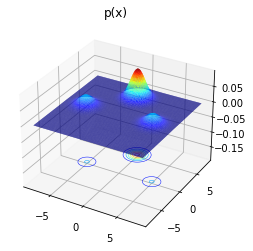

In [14]:
width = 8
fig = plot_distribution(target, bounds=[[-width, width], [-width, width]])

In [15]:
epochs = int(1e4)
batch_size = int(1e3)
dim = 2
n_samples_estimation = int(1e6)
KPI_n_samples = int(1e4)
flow_type="IAF"
lr = 4e-4

# var directly

In [23]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=10, scaling_factor=4.0, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=lr)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)


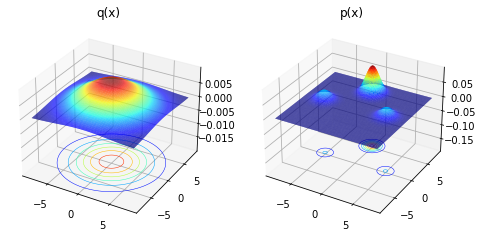

In [24]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

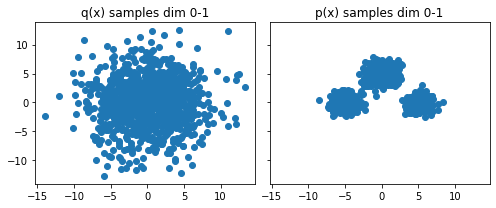

In [25]:
samples_fig_before = plot_samples(tester) 

In [26]:
def var_loss(x_samples_not_used, log_q_x, log_p_x):
    log_w = log_p_x - log_q_x
    return torch.var(log_w)

In [27]:
tester.loss = var_loss

In [28]:
tester.optimizer.param_groups[0]["lr"] = 1e-4

loss: 88.54199677962242, mean log p_x -12.438775590361958:   0%|                                                                                              | 0/1000 [00:00<?, ?it/s]

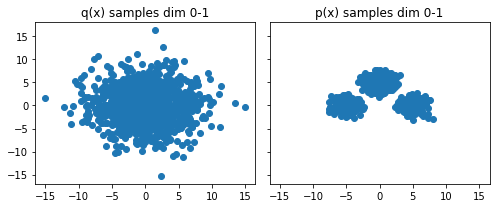

loss: 31.05282076346032, mean log p_x -9.164762721158606:  10%|████████▌                                                                             | 99/1000 [00:06<00:45, 19.73it/s]

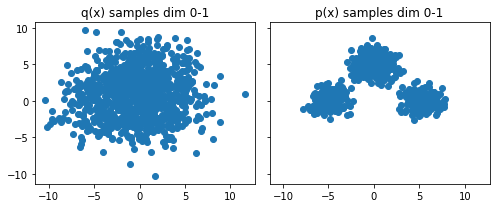

loss: 11.906812086699885, mean log p_x -7.566117409559112:  20%|████████████████▊                                                                   | 200/1000 [00:12<00:41, 19.34it/s]

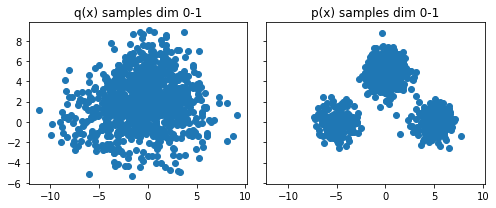

loss: 7.018307688195588, mean log p_x -6.488984414835515:  30%|█████████████████████████▎                                                           | 298/1000 [00:19<00:38, 18.25it/s]

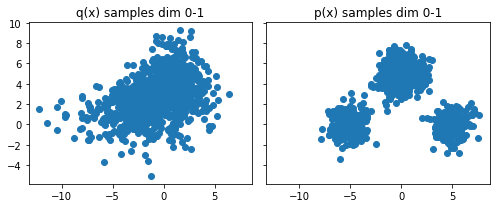

loss: 3.3819267011421936, mean log p_x -5.269291573939772:  40%|█████████████████████████████████▌                                                  | 400/1000 [00:25<00:30, 19.71it/s]

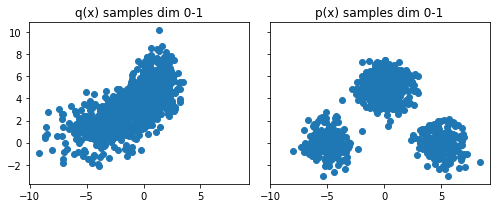

loss: 1.949075769922468, mean log p_x -4.652186102663785:  50%|██████████████████████████████████████████▌                                          | 500/1000 [00:31<00:25, 19.93it/s]

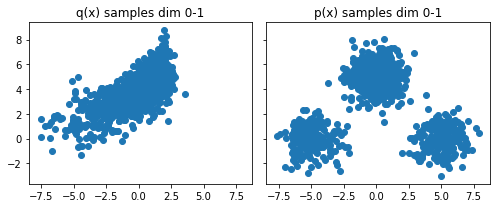

loss: 0.6941196224363344, mean log p_x -3.764001751067234:  60%|██████████████████████████████████████████████████▏                                 | 598/1000 [00:37<00:21, 19.02it/s]

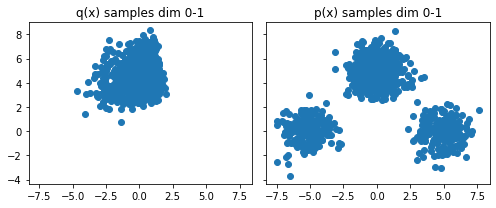

loss: 0.06470632389568137, mean log p_x -3.300922084030608:  70%|██████████████████████████████████████████████████████████                         | 699/1000 [00:44<00:16, 18.50it/s]

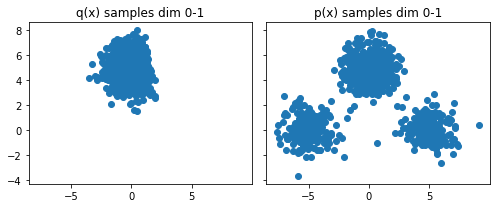

loss: 0.028451352896941933, mean log p_x -3.3802383639258657:  80%|████████████████████████████████████████████████████████████████▊                | 800/1000 [00:50<00:09, 20.40it/s]

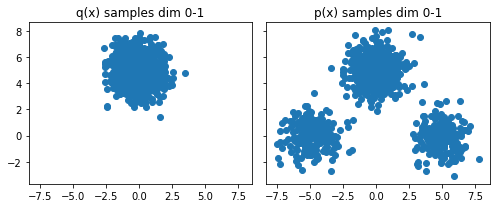

loss: 0.017912807614270537, mean log p_x -3.318396581223821:  90%|█████████████████████████████████████████████████████████████████████████▋        | 898/1000 [00:56<00:05, 19.56it/s]

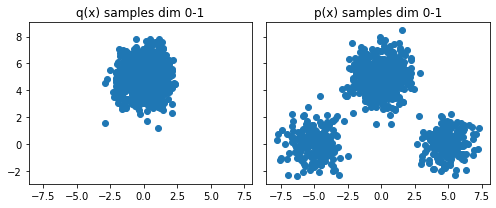

loss: 0.007865349751718773, mean log p_x -3.2850771409715915: 100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 16.01it/s]


In [29]:
history = tester.train(1000, batch_size=batch_size, KPI_batch_size=KPI_n_samples,
                       clip_grad_norm=True, max_grad_norm=1, intermediate_plots=True, plotting_func=plotter) 
                       #clip_grad_max=True, max_grad_value=0.1) 

In [30]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 63.818075866461186 
estimate before training is 63.559882163775086 
estimate after training is 85.62369796520487 
effective sample size before is 0.12374811334903321
effective sample size after train is 0.019013774801647995
variance in weights is 5.159350083921993e-11


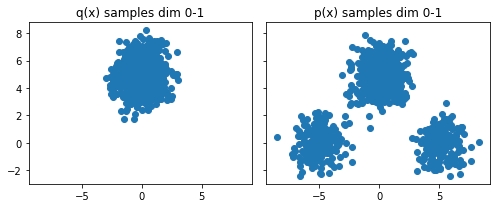

In [31]:
plot_samples(tester)

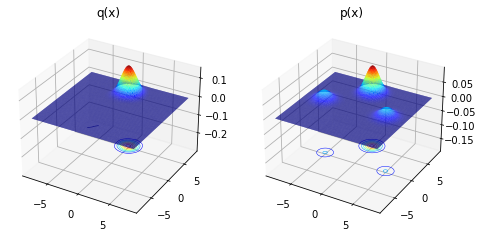

In [32]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

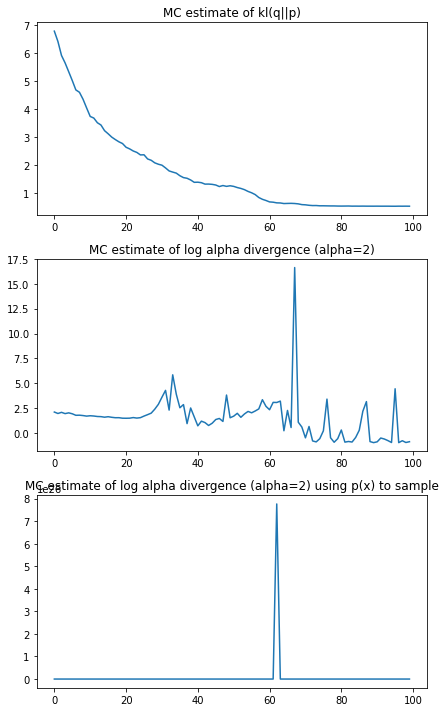

In [33]:
plot_divergences(history)

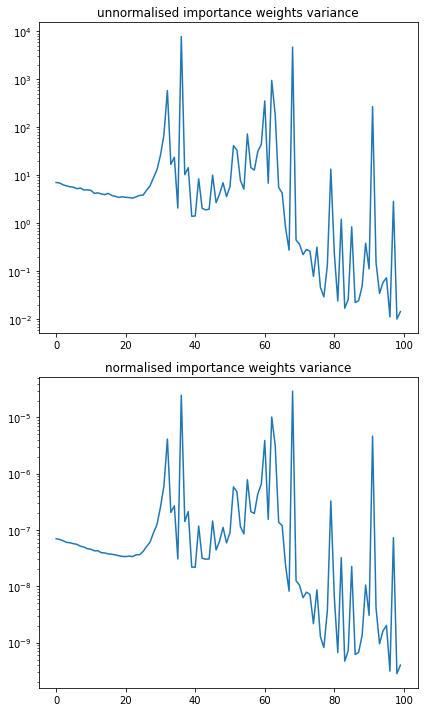

In [34]:
plot_sampling_info(history)

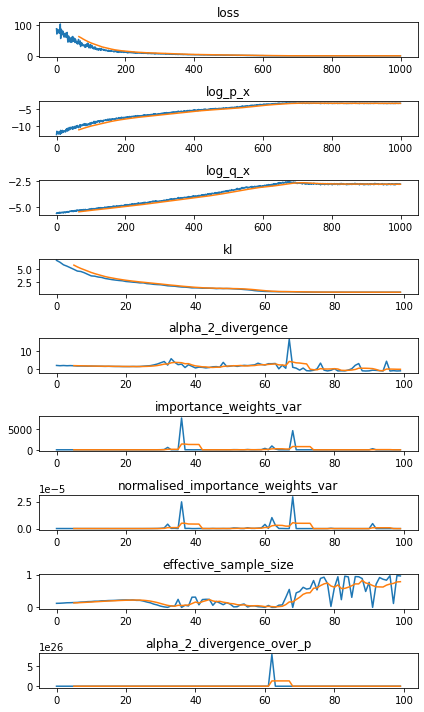

In [37]:
plot_history(history)

# DReG

In [7]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=10, scaling_factor=4.0, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=lr)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)


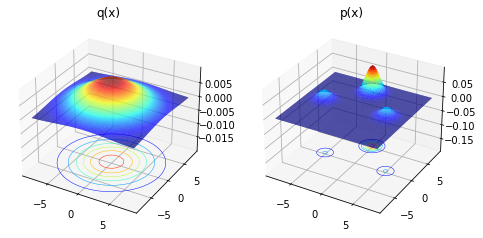

In [8]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

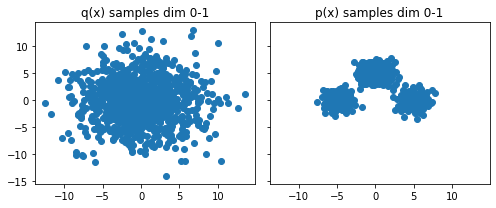

In [9]:
samples_fig_before = plot_samples(tester) 

loss: -0.17199915006714156, mean log p_x -4.345859939276477: 100%|██████████| 10000/10000 [33:19<00:00,  5.00it/s]


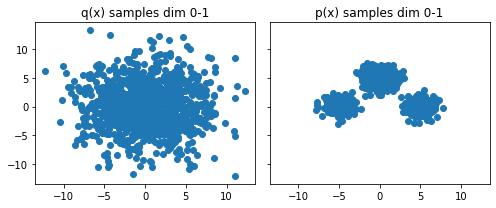

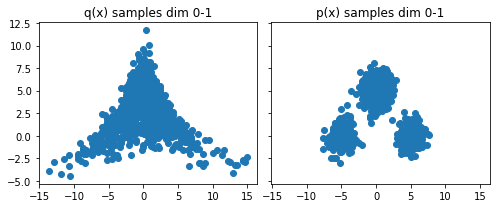

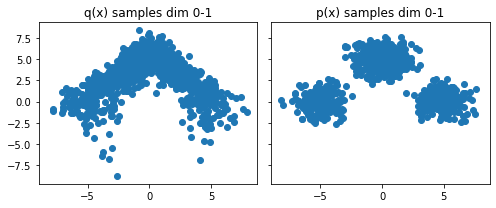

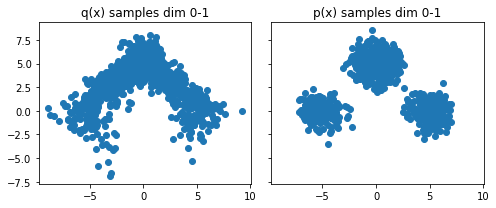

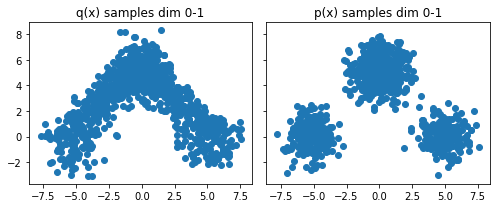

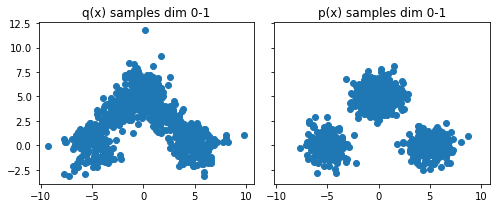

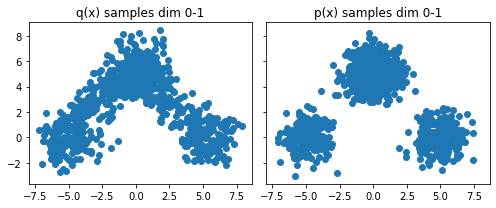

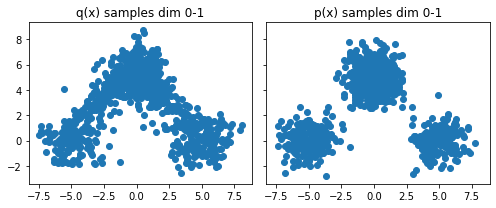

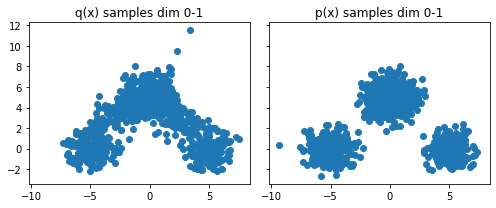

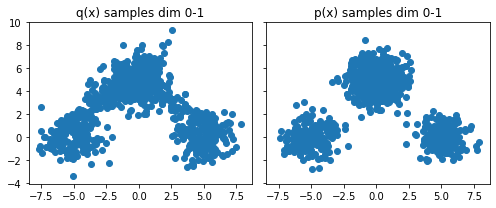

In [10]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples,
                       clip_grad_norm=True, max_grad_norm=1, intermediate_plots=True, plotting_func=plotter) 
                       #clip_grad_max=True, max_grad_value=0.1) 

In [11]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 63.818075866461186 
estimate before training is 63.559882163775086 
estimate after training is 63.78647472696112 
effective sample size before is 0.12374811334903324
effective sample size after train is 0.7971096563605854
variance in weights is 2.5453279220867017e-13


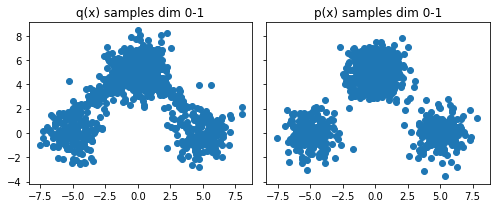

In [12]:
plot_samples(tester)

In [13]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

ValueError: The value argument must be within the support

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
plot_history(history)

# KL

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=20, scaling_factor=4.0, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=1e-3, #4e-4,
                                  weight_decay=1e-4)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

In [ ]:
samples_fig_before = plot_samples(tester) 

In [ ]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples, 
                       clip_grad_norm=True, max_grad_norm=1, intermediate_plots=True)

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
tester.learnt_sampling_dist.check_forward_backward_consistency()

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
hist_plot = plot_history(history)

In [ ]:
info['normalised_sampling_weights'].max(), info['normalised_sampling_weights'].min()

## let's calculate the recalculate the importance weights for inspection

In [ ]:
with torch.no_grad():
    x_samples, log_q_x = tester.learnt_sampling_dist(int(1e6))

In [ ]:
plt.scatter(x_samples[:1000, 0].detach(), x_samples[:1000, 1].detach())

In [ ]:
log_p_x = tester.target_dist.log_prob(x_samples)

In [ ]:
log_w = log_p_x - log_q_x

In [ ]:
log_w.max(), log_w.min()

In [ ]:
max_index = torch.argmax(log_w)
max_index

In [ ]:
target_samples = tester.target_dist.sample((1000,)).detach()
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.3, c="b")
plt.scatter(x_samples[:10000, 0].detach(), x_samples[:10000, 1].detach(), alpha=0.05, c="g")
plt.scatter(x_samples[max_index, 0], x_samples[max_index, 1], c="r", marker="x", s=50)
plt.legend(["target samples", "flow samples", "max weight"])